In [4]:
import galsim
import ngmix
import numpy as np

import proplot as pplt

%matplotlib inline

In [47]:
def make_sim(
    *,
    seed=10,
    g1=0,
    g2=0,
    dim=150,
    buff=50,
    scale=0.25,
    dens=100,
    ngrid=None,
    snr=1e2,
    add_edge=True,
):
    rng = np.random.RandomState(seed=seed)

    half_loc = (dim-buff*2)*scale/2

    if ngrid is None:
        area_arcmin2 = ((dim - buff*2)*scale/60)**2
        nobj = int(dens * area_arcmin2)
        x = rng.uniform(low=-half_loc, high=half_loc, size=nobj)
        y = rng.uniform(low=-half_loc, high=half_loc, size=nobj)
    else:
        half_ngrid = (ngrid-1)/2
        x, y = np.meshgrid(np.arange(ngrid), np.arange(ngrid))
        x = (x.ravel() - half_ngrid)/half_ngrid * half_loc
        y = (y.ravel() - half_ngrid)/half_ngrid * half_loc
        nobj = x.shape[0]

    cen = (dim-1)/2
    psf_dim = 53
    psf_cen = (psf_dim-1)/2

    psf = galsim.Gaussian(fwhm=0.9)
    gals = []
    for ind in range(nobj):
        u, v = rng.uniform(low=-scale, high=scale, size=2)
        u += x[ind]
        v += y[ind]
        gals.append(galsim.Exponential(half_light_radius=0.5).shift(u, v))
    
    # add one on the edge
    if add_edge:
        gals.append(galsim.Exponential(
                half_light_radius=2
            ).shear(
                g1=0.5, g2=-0.2
            ).withFlux(
                1000*5
            ).shift(dim*scale/2, 0)
        )
    gals = galsim.Add(gals)
    gals = gals.shear(g1=g1, g2=g2)
    gals = galsim.Convolve([gals, psf])

    im = gals.drawImage(nx=dim, ny=dim, scale=scale).array
    psf_im = psf.drawImage(nx=psf_dim, ny=psf_dim, scale=scale).array

    nse = (
        np.sqrt(np.sum(
            galsim.Convolve([
                psf,
                galsim.Exponential(half_light_radius=0.5),
            ]).drawImage(scale=scale).array**2)
        )
        / snr
    )

    im += rng.normal(size=im.shape, scale=nse)
    wgt = np.ones_like(im) / nse**2
    jac = ngmix.DiagonalJacobian(scale=scale, row=cen, col=cen)
    psf_jac = ngmix.DiagonalJacobian(scale=scale, row=psf_cen, col=psf_cen)

    obs = ngmix.Observation(
        image=im,
        weight=wgt,
        jacobian=jac,
        noise=rng.normal(size=im.shape, scale=nse),
        ormask=np.zeros_like(im, dtype=np.int32),
        bmask=np.zeros_like(im, dtype=np.int32),
        psf=ngmix.Observation(
            image=psf_im,
            jacobian=psf_jac,
        ),
    )
    mbobs = ngmix.MultiBandObsList()
    obslist = ngmix.ObsList()
    obslist.append(obs)
    mbobs.append(obslist)
    return mbobs


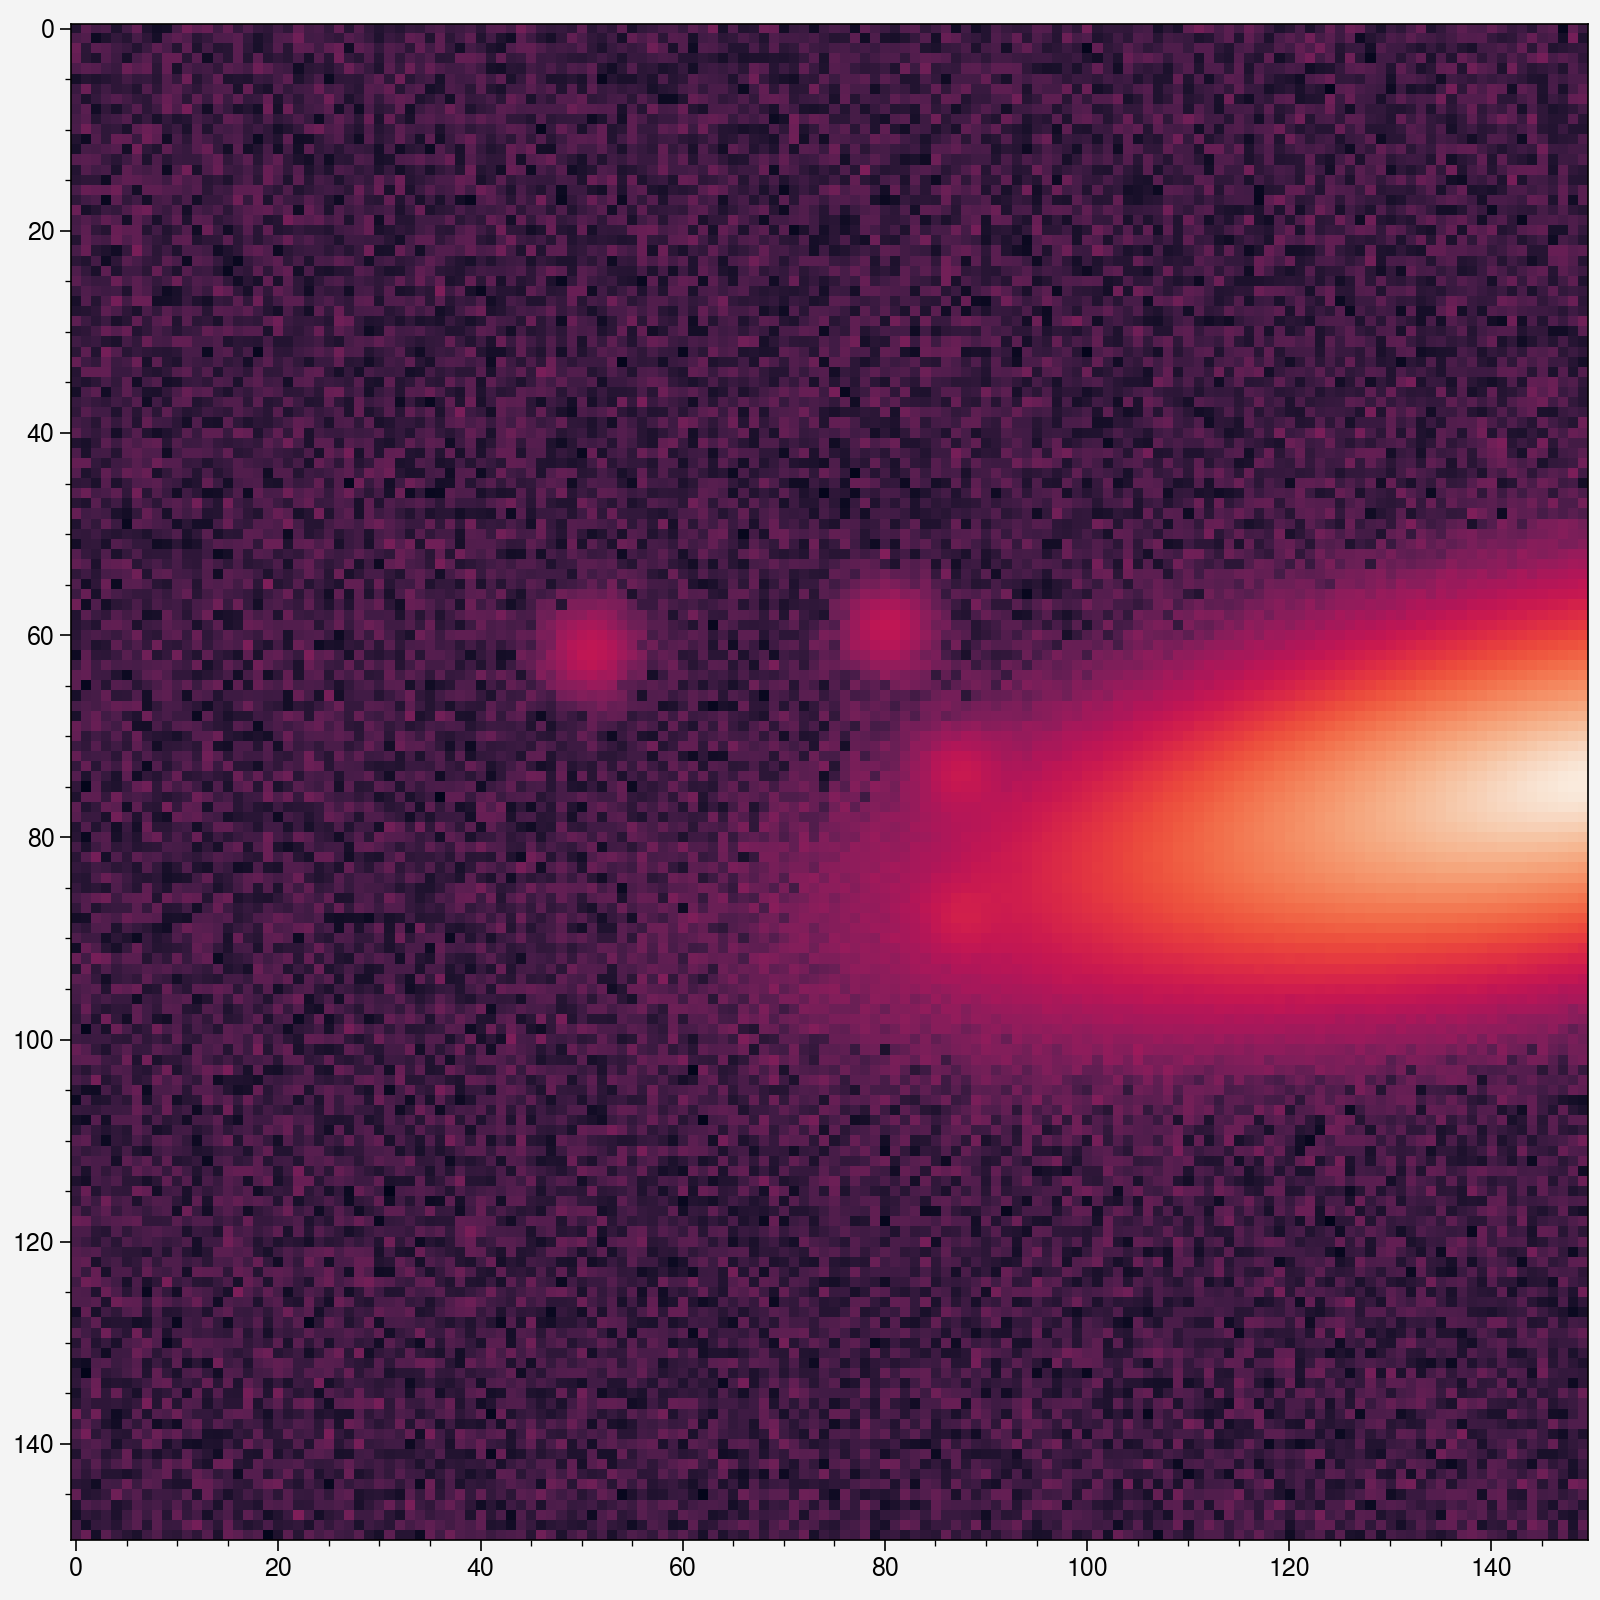

In [48]:
mbobs = make_sim()

fig, axs = pplt.subplots(figsize=(8, 8))
axs.imshow(np.arcsinh(mbobs[0][0].image*np.sqrt(mbobs[0][0].weight)), cmap="rocket")
axs.grid(False)

In [49]:
from ngmix.metacal import get_all_metacal

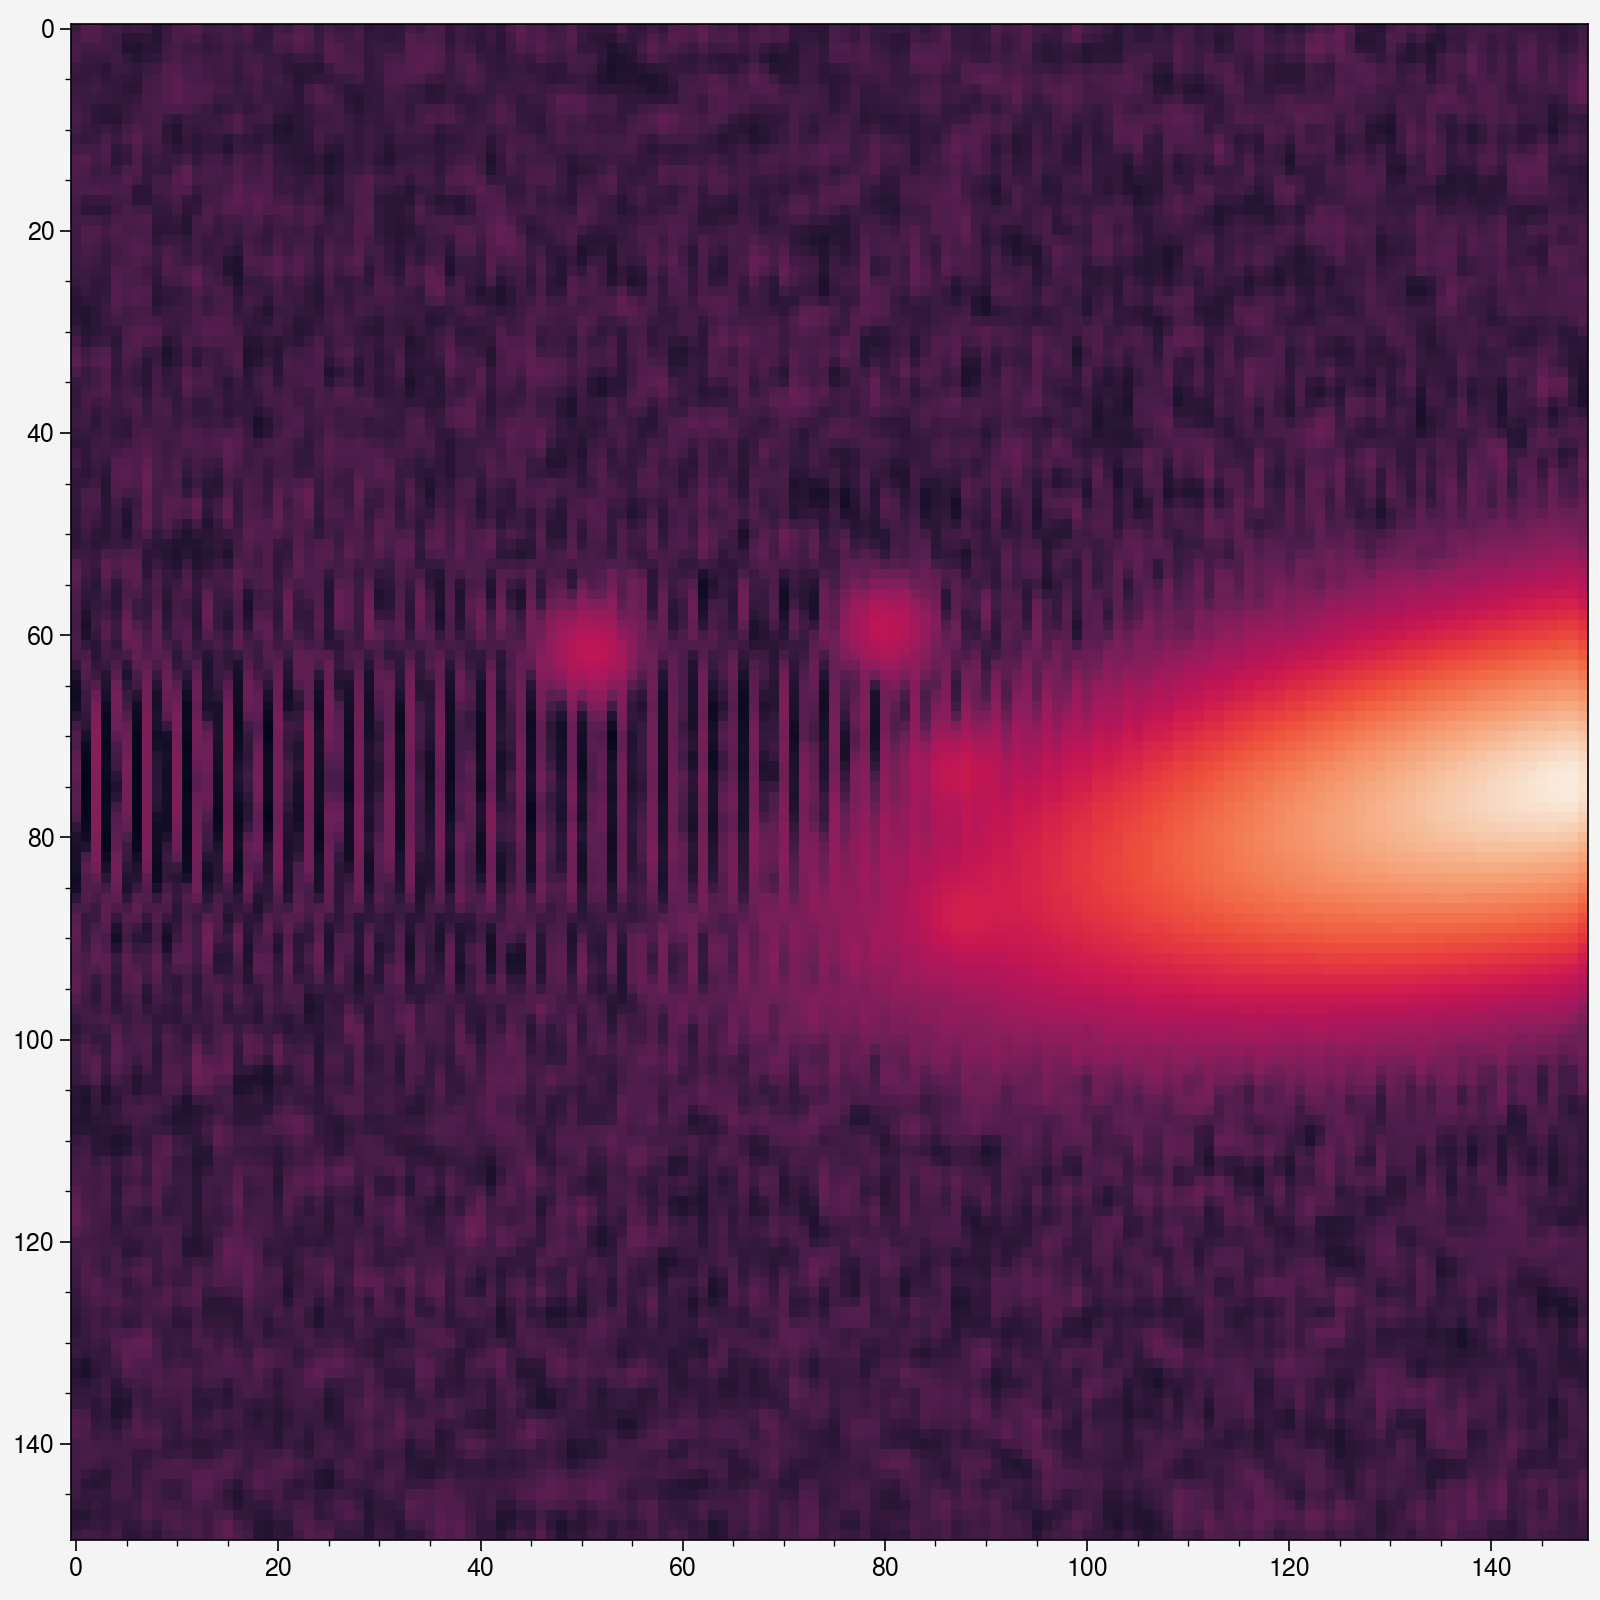

In [52]:
res = get_all_metacal(mbobs[0][0], use_noise_image=True)

fig, axs = pplt.subplots(figsize=(8, 8))
axs.imshow(np.arcsinh(res["noshear"].image * np.sqrt(mbobs[0][0].weight)), cmap="rocket")
axs.grid(False)

In [53]:
from metadetect.masking import apply_apodization_corrections

In [54]:
apply_apodization_corrections(
    mbobs=mbobs,
    ap_rad=2,
    mask_bit_val=2**4,
)

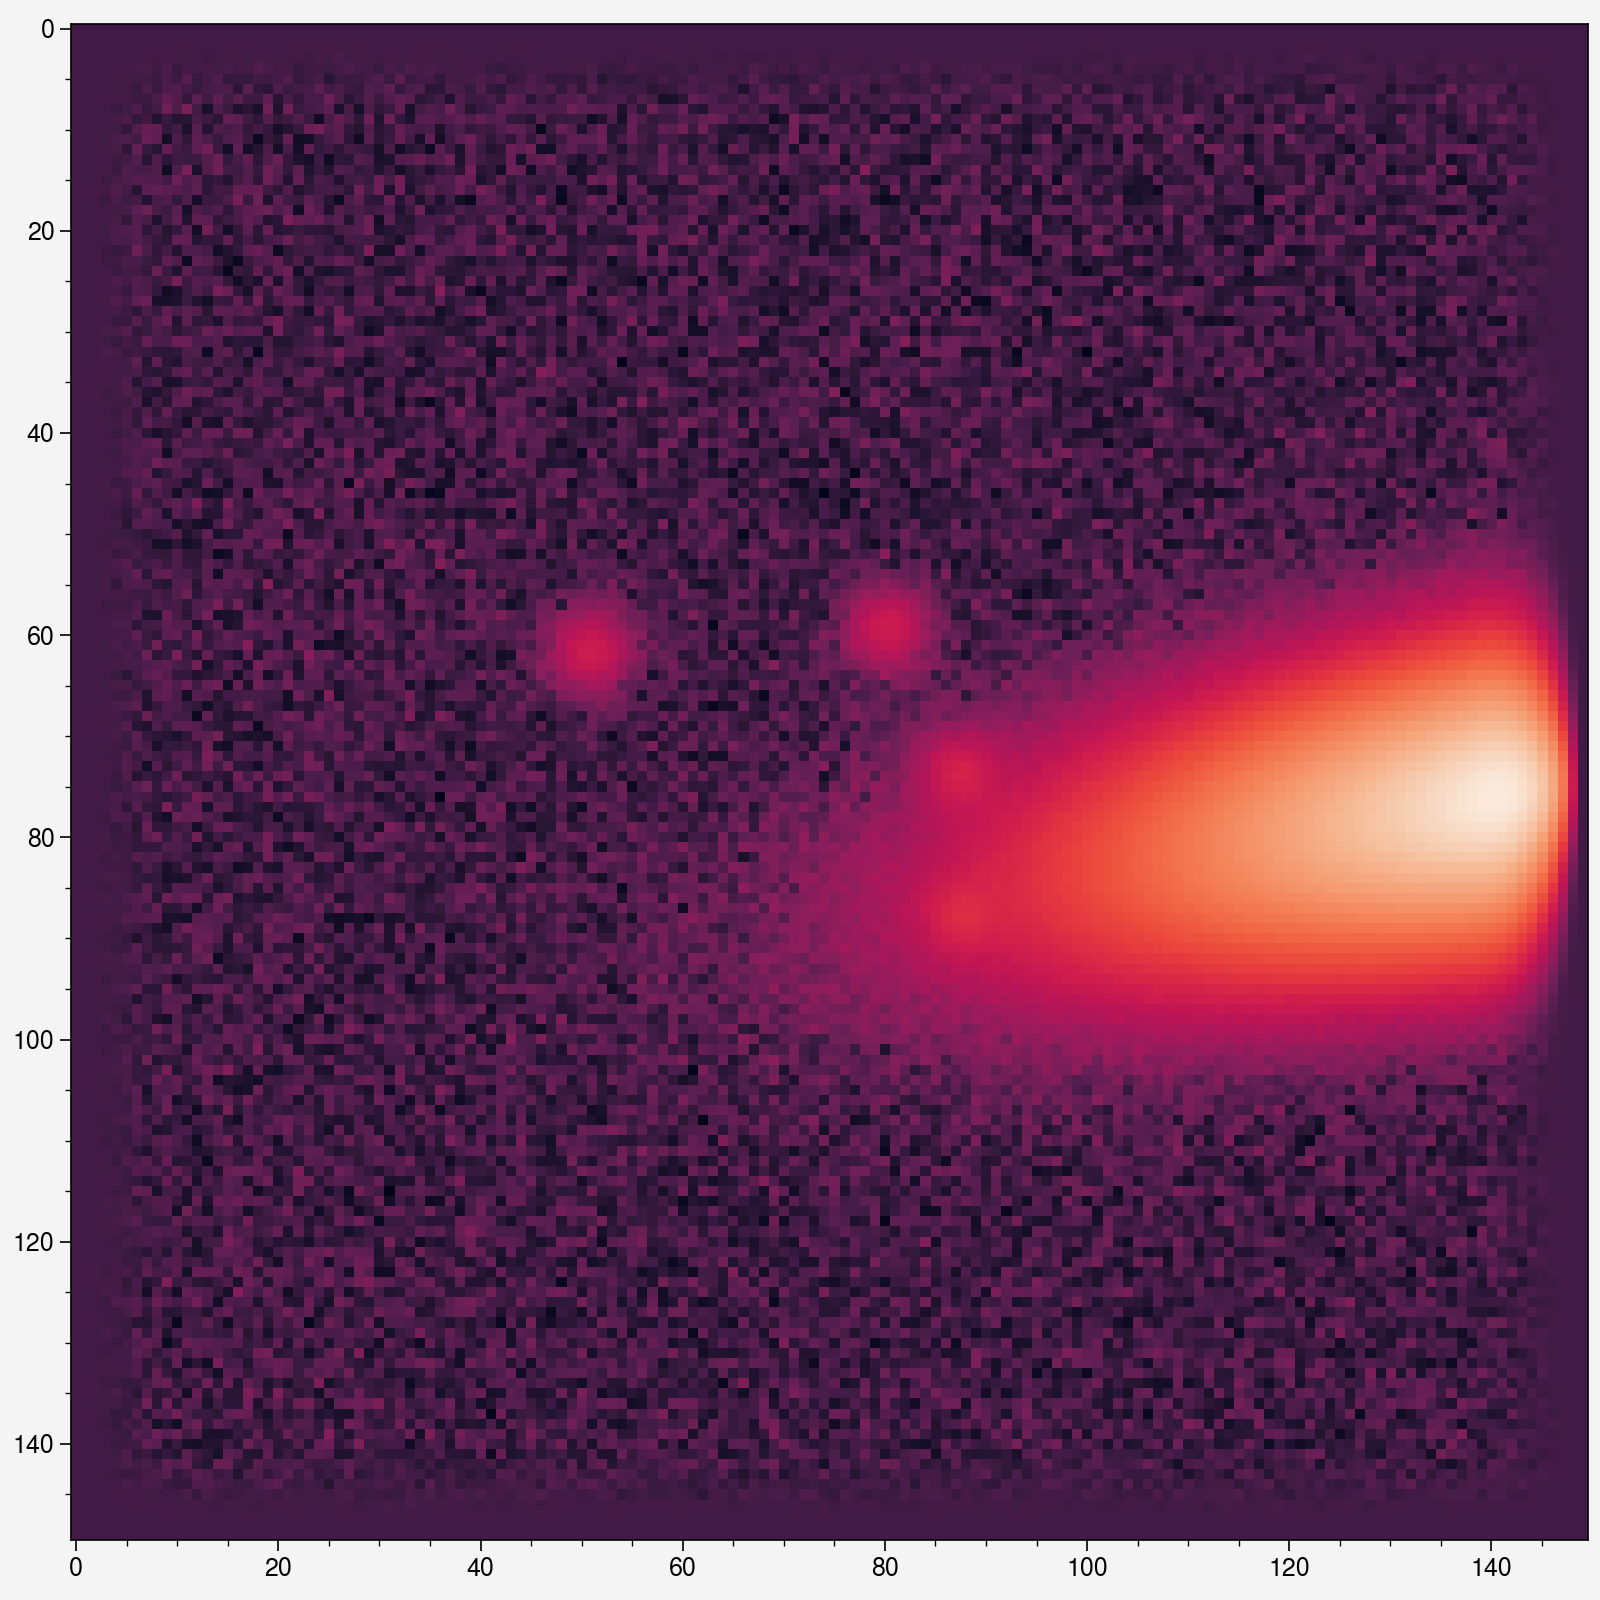

In [57]:
fig, axs = pplt.subplots(figsize=(8, 8))
axs.imshow(np.arcsinh(mbobs[0][0].image*np.median(np.sqrt(mbobs[0][0].weight))), cmap="rocket")
axs.grid(False)

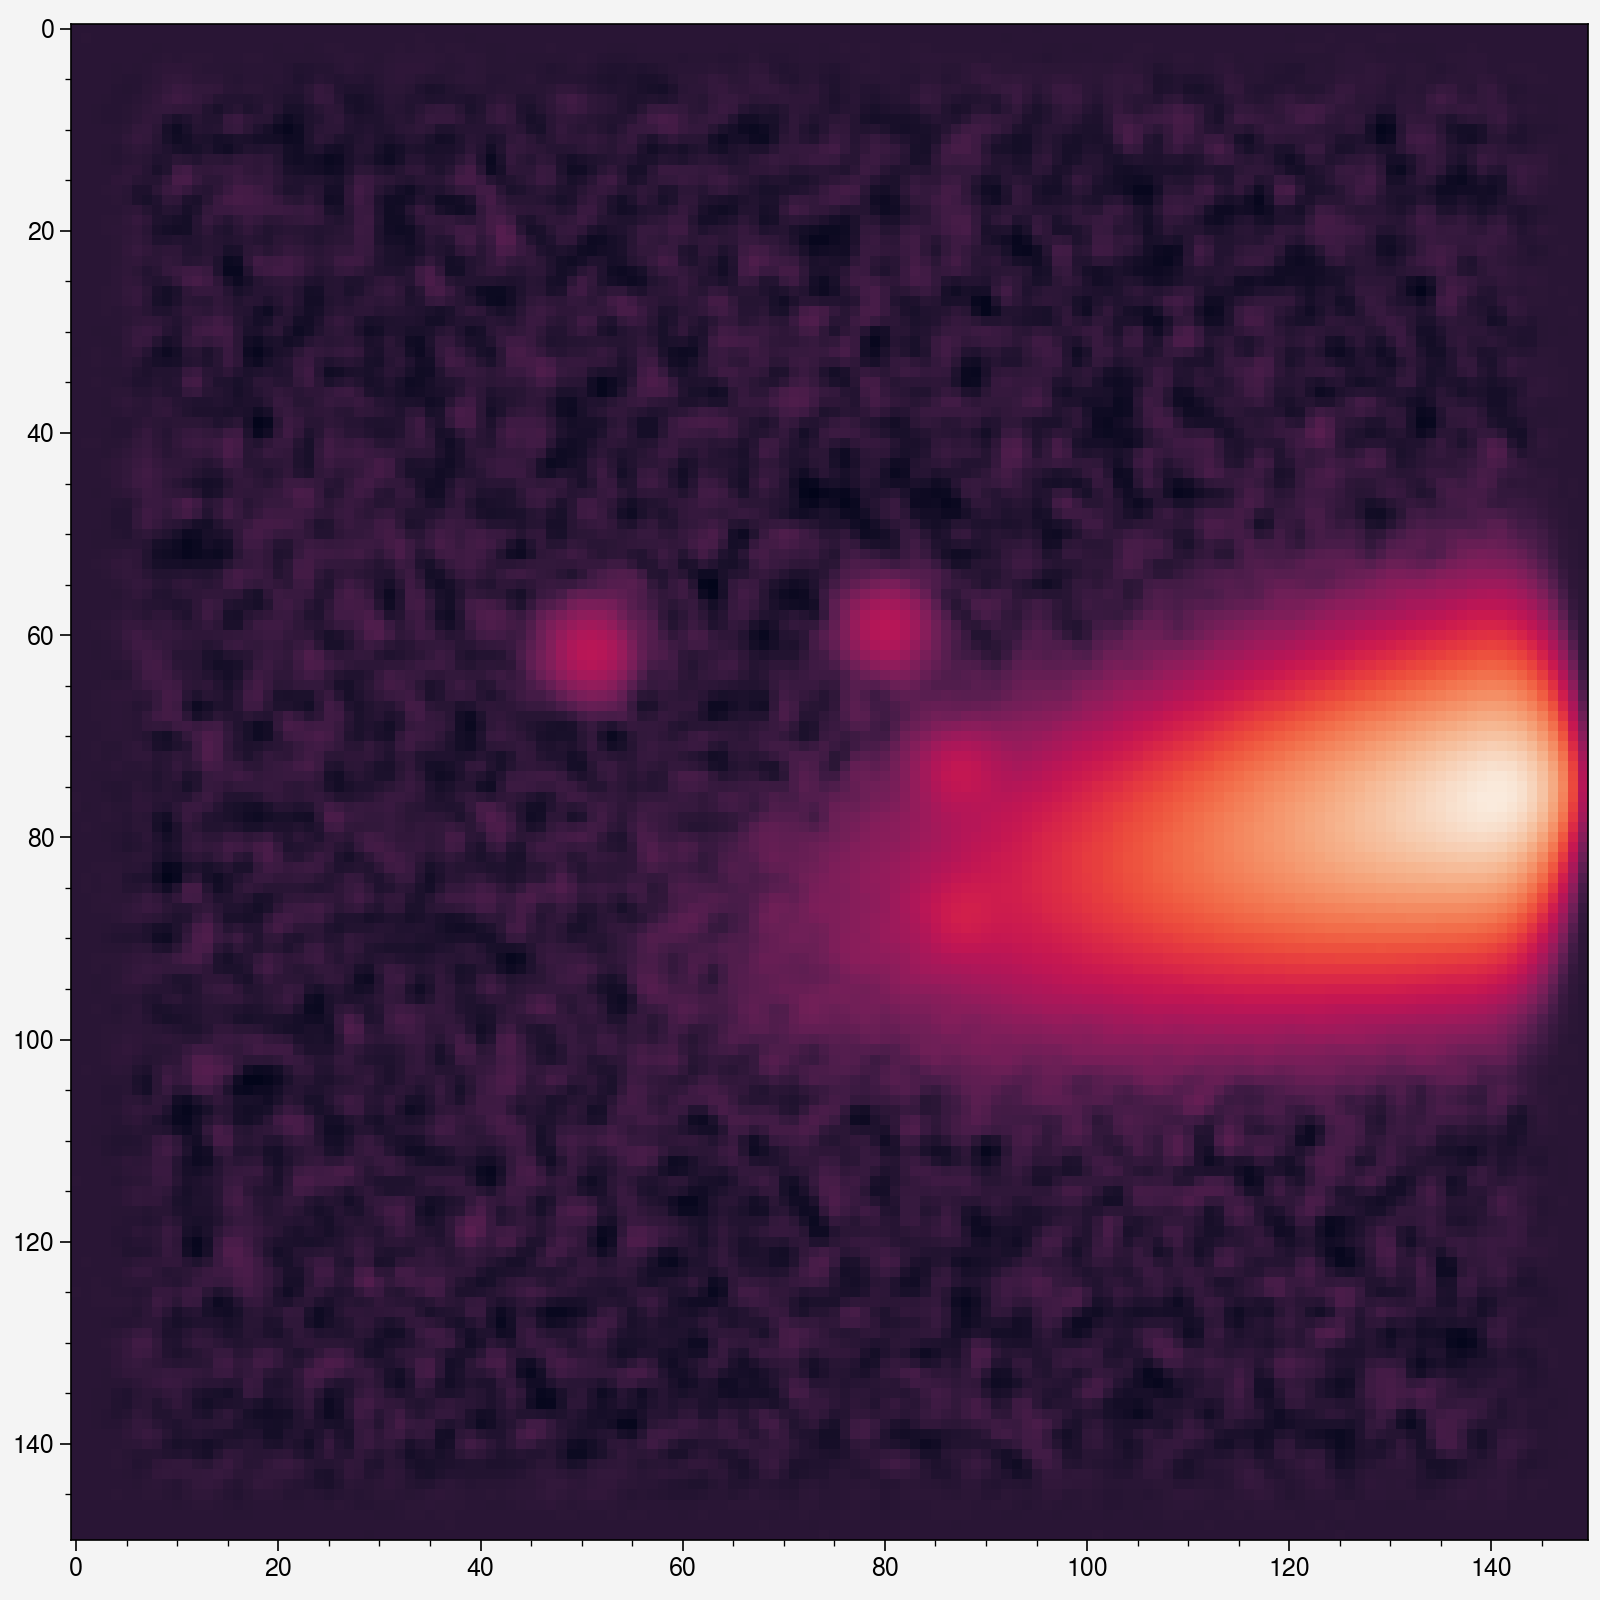

In [58]:
res = get_all_metacal(mbobs[0][0], use_noise_image=True)

fig, axs = pplt.subplots(figsize=(8, 8))
axs.imshow(np.arcsinh(res["noshear"].image * np.median(np.sqrt(mbobs[0][0].weight))), cmap="rocket")
axs.grid(False)